<a href="https://colab.research.google.com/github/mhasan502/Age_Estimation/blob/master/Age_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# custom_loader

In [1]:
!pip install parse

  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=cef02a34fc2a15da6b786ae8b115a711e4bde0edd4dfb5c9c2248bf187b01487
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built parse


In [2]:
import os
import sys
import torch
from PIL import Image
from parse import parse
from torch.utils.data import DataLoader, Dataset

In [3]:
class AgeDBHandler:
    def __init__(self, datasets_dir, preload=False, use_preprocessed=True, device: torch.device = torch.device('cpu')):
        self.device = device
        self.preload = preload

        self.datasets_dir = datasets_dir
        self.directory = os.path.join(datasets_dir, 'AgeDB')

        self.trainDataset = None
        self.testDataset = None
        self.validateDataset = None

        self._prepare_on_disk()

    def get_loaders(self, transform, train_size=0.7, validate_size=0.2, test_size=0.1, batch_size=15, **kwargs):
        if round(train_size + validate_size + test_size, 1) > 1.0:
            sys.exit("Sum of the percentages should be less than 1. it's " +
                     str(train_size + validate_size + test_size) + " now!")

        dataset = AgeDBDataset(directory=self.directory,
                               transform=transform,
                               preload=self.preload,
                               device=self.device,
                               **kwargs)

        train_len = int(len(dataset) * train_size)
        validate_len = int(len(dataset) * validate_size)
        test_len = int(len(dataset) * test_size)
        others_len = len(dataset) - train_len - validate_len - test_len

        self.trainDataset, self.validateDataset, self.testDataset, _ = torch.utils.data.random_split(
            dataset, [train_len, validate_len, test_len, others_len])

        # noinspection PyUnusedLocal
        dataset = None

        train_loader = DataLoader(self.trainDataset, batch_size=batch_size)
        validate_loader = DataLoader(self.validateDataset, batch_size=batch_size)
        test_loader = DataLoader(self.testDataset, batch_size=batch_size)

        return train_loader, validate_loader, test_loader

    def _prepare_on_disk(self):
        if os.path.exists(self.directory):
            if len(os.listdir(self.directory)) != 0:
                print('AgeDB Already Exists on ' +
                      self.directory + '.We will use it!')
                return
            
        print('Could not find AgeDB on', self.directory)
        print('Looking for ', self.zipFile)

In [4]:
class AgeDBDataset(Dataset):
    def __init__(self, directory, transform, preload=False, device: torch.device = torch.device('cpu'), **kwargs):
        self.device = device
        self.directory = directory if kwargs.get('usePreprocessed', 0) == 0 else os.path.join(directory, 'preProcessed')
        self.transform = transform
        gender_to_class_id = {'m': 0, 'f': 1}
        self.labels = []
        self.images = []
        self.preload = preload

        for i, file in enumerate(os.listdir(self.directory)):
            if file.endswith(('_2.jpg', '_3.jpg')):  # TODO
                continue
            file_labels = parse('{}_{}_{age}_{gender}.jpg', file)
            
            if file_labels is None:
                continue
                
            if self.preload:
                image = Image.open(os.path.join(self.directory, file)).convert('RGB')
                
                if self.transform is not None:
                    image = self.transform(image).to(self.device)
            else:
                image = os.path.join(self.directory, file)

            self.images.append(image)
            gender = gender_to_class_id[file_labels['gender']]
            age = int(file_labels['age'])
            self.labels.append({
                'age': age,
                'gender': gender
            })
        pass

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]

        if not self.preload:
            image = Image.open(image).convert('RGB')
            if self.transform is not None:
                image = self.transform(image).to(self.device)

        labels = {
            'age': self.labels[idx]['age'], 
            'gender': self.labels[idx]['gender']
            }
        return image.to(self.device), labels

# Preprocessing

In [5]:
from torch import nn
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Loading Dataset

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
dataset = AgeDBDataset(
    directory = '/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB',
    transform = ToTensor(),
    device = device
)

# Dataset Attributes

In [9]:
len(dataset)

16488

In [10]:
dataset[0]

(tensor([[[0.4196, 0.4157, 0.4157,  ..., 0.5020, 0.4824, 0.4667],
          [0.4196, 0.4196, 0.4157,  ..., 0.4980, 0.4745, 0.4588],
          [0.4235, 0.4196, 0.4157,  ..., 0.4902, 0.4667, 0.4510],
          ...,
          [0.2549, 0.2588, 0.2627,  ..., 0.0627, 0.0627, 0.0667],
          [0.2471, 0.2510, 0.2549,  ..., 0.0627, 0.0588, 0.0627],
          [0.2392, 0.2431, 0.2471,  ..., 0.0627, 0.0588, 0.0627]],
 
         [[0.3333, 0.3294, 0.3294,  ..., 0.4314, 0.4118, 0.3961],
          [0.3333, 0.3333, 0.3294,  ..., 0.4275, 0.4039, 0.3882],
          [0.3373, 0.3333, 0.3294,  ..., 0.4196, 0.3961, 0.3804],
          ...,
          [0.1961, 0.2000, 0.2039,  ..., 0.0667, 0.0667, 0.0706],
          [0.1882, 0.1922, 0.1961,  ..., 0.0667, 0.0627, 0.0667],
          [0.1804, 0.1843, 0.1882,  ..., 0.0667, 0.0627, 0.0667]],
 
         [[0.2824, 0.2784, 0.2784,  ..., 0.3843, 0.3647, 0.3569],
          [0.2824, 0.2824, 0.2784,  ..., 0.3804, 0.3569, 0.3490],
          [0.2863, 0.2824, 0.2784,  ...,

In [12]:
type(dataset[0])

tuple

In [11]:
dataset.labels[0]

{'age': 32, 'gender': 1}

In [13]:
print(dataset.images[0])

/content/gdrive/MyDrive/Colab Notebooks/AgeDBDataset/AgeDB/15588_KateOMara_32_f.jpg


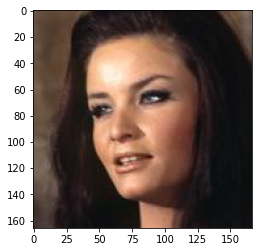

In [14]:
plt.figure()
plt.imshow(plt.imread(dataset.images[0]))

In [15]:
age = []
gender = []
for i in range(len(dataset)):
    age.append(dataset.labels[i]['age'])
    gender.append(dataset.labels[i]['gender'])

In [16]:
print("Highest Age Value: "+str(max(age))+"\nLowest Age Value: "+str(min(age)))

Highest Age Value: 101
Lowest Age Value: 1


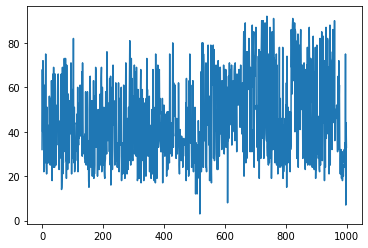

In [17]:
plt.plot(age[:1000])
plt.show()